# Setup (Packages)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.colors

from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np

# Modified Sigmoid Neuron Class

In [2]:
class sigmoid:
    def __init__(self, w_init, b_init, algo):
        self.w = w_init
        self.b = b_init
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.algo = algo
    
    def sigmoid(self, x, w = None, b = None):
        if w is None: w = self.w
        if b is None: b = self.b
        return 1.0 / (1.0 + np.exp(-(w * x + b)))
    
    def error(self, X, Y, w = None, b = None):
        err = 0
        if w is None: w = self.w
        if b is None: b = self.b

        for x, y in zip(X, Y):
            err += 0.5 * (self.sigmoid(x, w, b) - y) ** 2
        return err
    
    def grad_w(self, x, y, w = None, b = None):
        if w is None: w = self.w
        if b is None: b = self.b

        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * y_pred * (1 - y_pred) * x
    
    def grad_b(self, x, y, w = None, b = None):
        if w is None: w = self.w
        if b is None: b = self.b

        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * y_pred * (1 - y_pred)
    
    def fit(self, X, Y, epochs = 1, eta = 0.001, gamma = 0.9, minibatch_size = 1, eps = 1e-8, 
            beta = 0.9, beta1 = 0.9, beta2 = 0.9):

        if self.algo == 'GD':
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                m = X.shape[0]
                self.w = self.w - (eta * (dw / m))
                self.b -= (eta * (db / m))
                self.append_log(X, Y)
        
        if self.algo == 'Momentum':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                m = X.shape[0]
                v_w = gamma * v_w + eta * dw
                v_b = gamma * v_b + eta * db
                self.w = self.w - v_w
                self.b = self.b - v_b
                self.append_log(X, Y)
        
        if self.algo == 'NAG':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                v_w = gamma * v_w
                v_b = gamma * v_b
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
                    db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
                v_w = v_w + eta * dw
                v_b = v_b + eta * db
                self.w = self.w - v_w
                self.b = self.b - v_b
                self.append_log(X, Y)
        
        if self.algo == 'MiniBatch':
            for i in range(epochs):
                dw, db = 0, 0
                points_seen = 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    points_seen += 1
                    if points_seen % minibatch_size == 0:
                        self.w -= eta * (dw / minibatch_size)
                        self.b -= eta * (db / minibatch_size)
                        self.append_log(X, Y)
                        dw, db = 0, 0
        
        if self.algo == 'AdaGrad':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w += dw ** 2
                v_b += db ** 2
                self.w = self.w - (eta / np.sqrt(v_w) + eps) * dw
                self.b = self.b - (eta / np.sqrt(v_b) + eps) * db
                self.append_log(X, Y)
        
        if self.algo == 'RMSProp':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = beta * v_w + (1 - beta) * (dw ** 2)
                v_b = beta * v_b + (1 - beta) * (db ** 2)
                self.w = self.w - (eta / np.sqrt(v_w) + eps) * dw
                self.b = self.b - (eta / np.sqrt(v_b) + eps) * db
                self.append_log(X, Y)
        
        if self.algo == 'Adam':
            v_w, v_b = 0, 0
            m_w, m_b = 0, 0
            num_updates = 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw = self.grad_w(x, y)
                    db = self.grad_b(x, y)
                    num_updates += 1
                    m_w = (beta1 * m_w) + (1 - beta1) * dw
                    m_b = (beta1 * m_b) + (1 - beta1) * db
                    v_w = (beta2 * v_w) + (1 - beta2) * (dw ** 2)
                    v_b = (beta2 * v_b) + (1 - beta2) * (db ** 2)
                    m_w_c = m_w / (1.0 - np.power(beta1, num_updates))
                    m_b_c = m_b / (1.0 - np.power(beta1, num_updates))
                    v_w_c = v_w / (1.0 - np.power(beta2, num_updates))
                    v_b_c = v_b / (1.0 - np.power(beta2, num_updates))
                    self.w = self.w - (eta / (np.sqrt(v_w_c) + eps)) * m_w_c
                    self.b = self.b - (eta / (np.sqrt(v_b_c) + eps)) * m_b_c
                    self.append_log(X, Y)

    def append_log(self, X, Y):
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(X, Y))


In [3]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

w_init = -6
b_init = 4.0

algo = 'Adam'

w_min = -7
w_max = 5

b_min = -7
b_max = 5

epochs = 200
eta = 0.5
gamma = 0.9
minibatch_size = 3
eps = 1e-8
beta = 0.9

animation_frames = 20

plot_2d = True

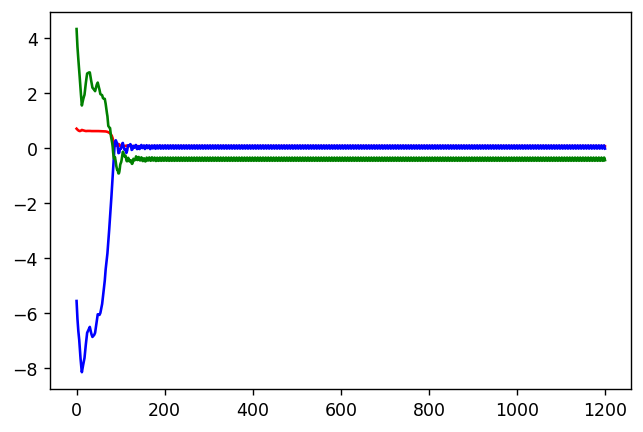

In [9]:
sn = sigmoid(w_init, b_init, algo)
sn.fit(X, Y, epochs=epochs, eta=eta, minibatch_size= minibatch_size, eps = eps, beta = beta)
plt.figure(figsize = (6, 4), dpi = 125)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')

#w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
#b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]

#plt.plot(w_diff, 'b--')
#plt.plot(b_diff, 'g--')
plt.show()

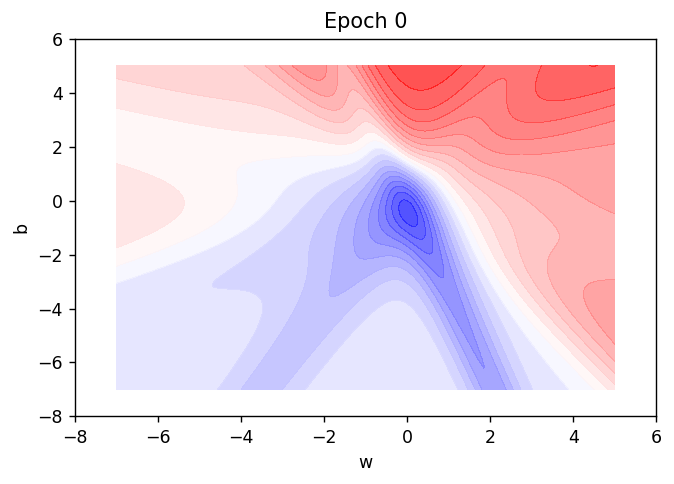

In [10]:
if plot_2d: 
  W = np.linspace(w_min, w_max, 256)
  b = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, b)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(figsize = (6, 4), dpi=125)
  ax = plt.subplot(111)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  title = ax.set_title('Epoch 0')
  plt.contourf(WW, BB, Z, 25, alpha=0.7, cmap=cm.bwr)
  plt.show()

In [11]:
def plot_animate_2d(i):
  i = int(i*(epochs/animation_frames))
  line.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  return line, title

In [12]:
if plot_2d: 
  i = 0
  line, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], color='black',marker='.')
  anim = animation.FuncAnimation(fig, func=plot_animate_2d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim

In [14]:
anim